In [ ]:
#Performing Predictive Modelling, Clustering, and Association Rules Mining on Black Friday Sales Dataset- 21/06/2024

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('black_friday_sales_train.csv')

print(df.head())

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN    8370.0  
1                 6.0                14.0   15200.0  
2                 NaN                 NaN   

In [7]:
print(df.isnull().sum())

print(df.describe())

df['Product_Category_2'].fillna(df['Product_Category_2'].median(), inplace=True)
df['Product_Category_3'].fillna(df['Product_Category_3'].median(), inplace=True)

df['City_Category'].fillna(df['City_Category'].mode()[0], inplace=True)

# Check if the columns exist before dropping
if 'User_ID' in df.columns and 'Product_ID' in df.columns:
    df.drop(['User_ID', 'Product_ID'], axis=1, inplace=True)
    print("Columns 'User_ID' and 'Product_ID' dropped successfully.")
else:
    print("One or both of 'User_ID' and 'Product_ID' columns not found in the DataFrame.")

print(df.isnull().sum())

Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      1
dtype: int64
          Occupation  Marital_Status  Product_Category_1  Product_Category_2  \
count  248463.000000   248463.000000       248463.000000       248463.000000   
mean        8.077492        0.410158            5.293239            9.585802   
std         6.537710        0.491863            3.743754            4.242346   
min         0.000000        0.000000            1.000000            2.000000   
25%         2.000000        0.000000            1.000000            8.000000   
50%         7.000000        0.000000            5.000000            9.000000   
75%        14.000000        1.000000            8.000000           14.000000   
max        20.000000       

In [9]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

df['Age_Group'] = pd.cut(df['Age'], bins=[0, 2, 6, 12, 18, 35, 60, np.inf],
                         labels=['Infant', 'Toddler', 'Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

df['Occupation_City'] = df['Occupation'].astype(str) + '_' + df['City_Category']

df.drop(['Age', 'Occupation', 'City_Category'], axis=1, inplace=True)

df = pd.get_dummies(df, columns=['Gender', 'Stay_In_Current_City_Years', 'Marital_Status', 'Age_Group', 'Occupation_City'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']] = scaler.fit_transform(df[['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']])

print(df.head())

   Product_Category_1  Product_Category_2  Product_Category_3  Purchase  \
0           -0.612552           -0.138085            0.173732 -0.189840   
1           -1.146776           -0.845242            0.173732  1.184906   
2            1.791457           -0.138085            0.173732 -1.588336   
3            1.791457            1.040511            0.173732 -1.661804   
4            0.723009           -0.138085            0.173732 -0.270553   

   Gender_F  Gender_M  Stay_In_Current_City_Years_0  \
0      True     False                         False   
1      True     False                         False   
2      True     False                         False   
3      True     False                         False   
4     False      True                         False   

   Stay_In_Current_City_Years_1  Stay_In_Current_City_Years_2  \
0                         False                          True   
1                         False                          True   
2                      

In [12]:
X = df.drop('Purchase', axis=1)
y = df['Purchase']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Q1 = df['Purchase'].quantile(0.25)
Q3 = df['Purchase'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Purchase'] >= Q1 - 1.5 * IQR) & (df['Purchase'] <= Q3 + 1.5 * IQR)]

X = df.drop('Purchase', axis=1)
y = df['Purchase']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(197783, 82) (49446, 82) (197783,) (49446,)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.8412693517090101
R^2 Score: 0.132521236825763


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


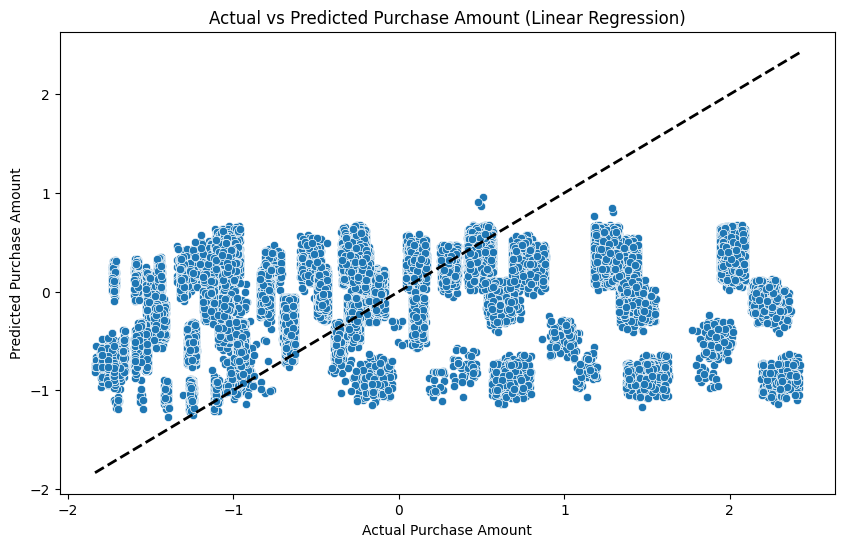

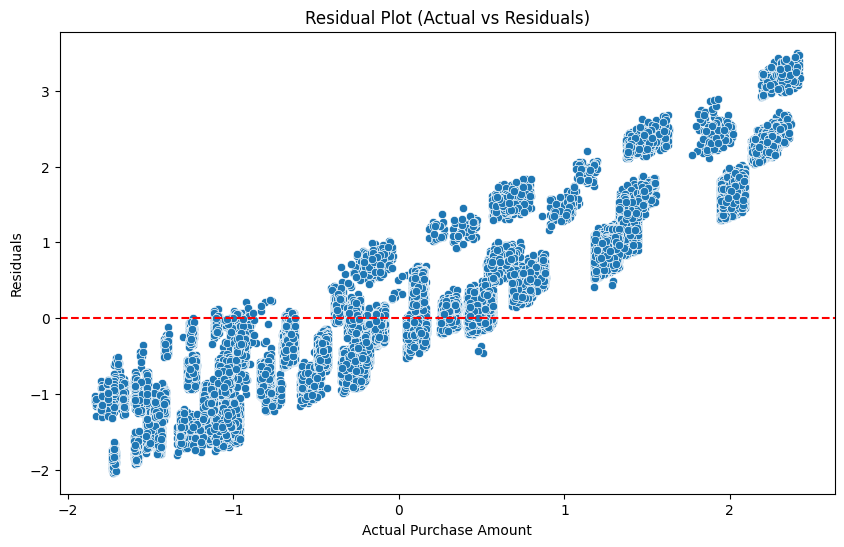

In [18]:
import seaborn as sns

# Scatter plot for Actual vs Predicted Purchase
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Purchase Amount (Linear Regression)')
plt.xlabel('Actual Purchase Amount')
plt.ylabel('Predicted Purchase Amount')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot (Actual vs Residuals)')
plt.xlabel('Actual Purchase Amount')
plt.ylabel('Residuals')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


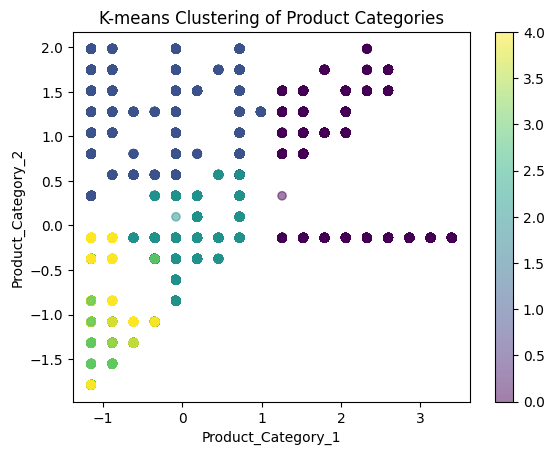

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X_cluster = df[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']]

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(X_cluster)

clusters = kmeans.predict(X_cluster)

plt.scatter(X_cluster['Product_Category_1'], X_cluster['Product_Category_2'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Product_Category_1')
plt.ylabel('Product_Category_2')
plt.title('K-means Clustering of Product Categories')
plt.colorbar()
plt.show()

In [16]:
from mlxtend.frequent_patterns import apriori, association_rules

df_apriori = df[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].copy()
df_apriori = df_apriori > 0

frequent_itemsets = apriori(df_apriori, min_support=0.05, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)

print(rules.head())

                                antecedents  \
0                      (Product_Category_1)   
1                      (Product_Category_2)   
2  (Product_Category_1, Product_Category_3)   
3  (Product_Category_3, Product_Category_2)   
4                      (Product_Category_1)   

                                consequents  antecedent support  \
0                      (Product_Category_2)            0.359929   
1                      (Product_Category_1)            0.337657   
2                      (Product_Category_2)            0.353998   
3                      (Product_Category_1)            0.331892   
4  (Product_Category_3, Product_Category_2)            0.359929   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.337657  0.158174    0.439459  1.301495  0.036641    1.181613   
1            0.359929  0.158174    0.468446  1.301495  0.036641    1.204150   
2            0.337657  0.154711    0.437039  1.294327  0.035181    1.176534  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


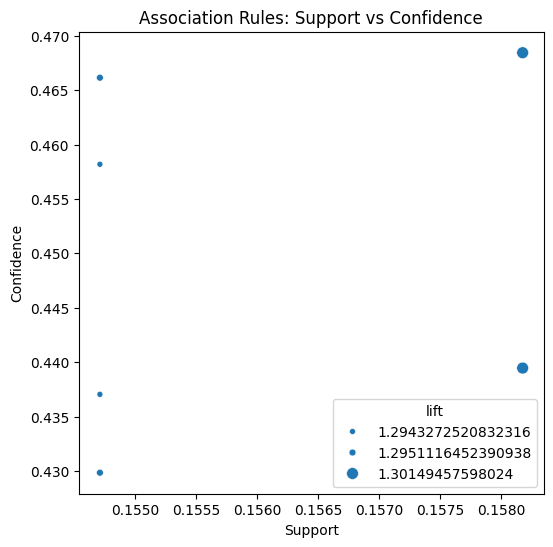

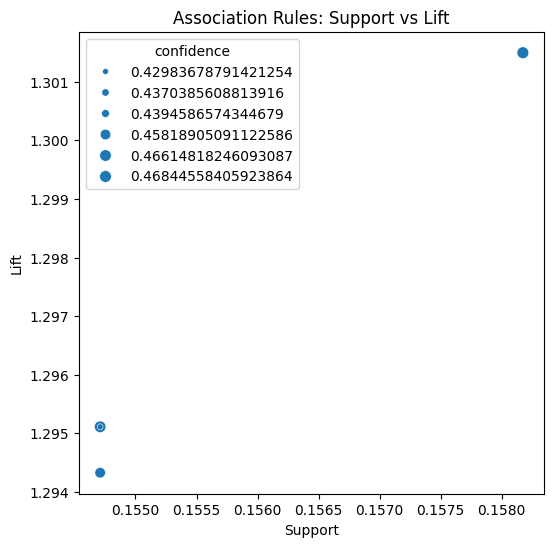

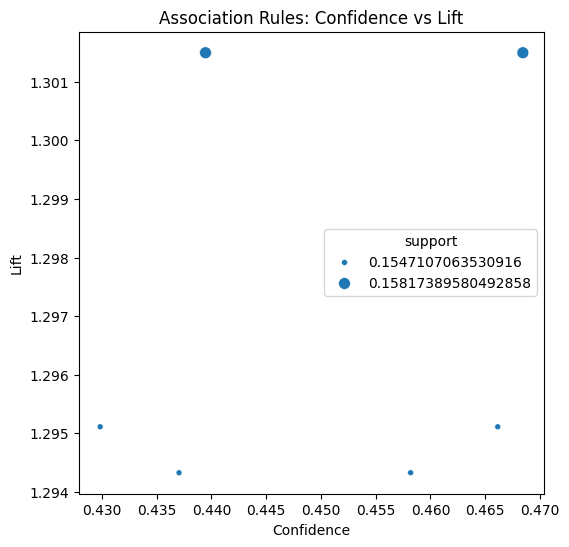

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for Support vs Confidence
plt.figure(figsize=(6, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules)
plt.title('Association Rules: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(x='support', y='lift', size='confidence', data=rules)
plt.title('Association Rules: Support vs Lift')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(x='confidence', y='lift', size='support', data=rules)
plt.title('Association Rules: Confidence vs Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()